In [1]:
%matplotlib inline
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from scipy.integrate import quad
import astropy.constants as const
import astropy.units as u
import h5py

import random

from numba import double
from numba.decorators import jit, autojit

In [2]:
c = const.c.to(u.km / u.s).value # km/s

# Load in z = 2.45 simulation data

Note: It has already been converted to hdf5 using `simdata_to_HDF5.ipynb`

We want to average over 2000 random sightlines of 50 boxes (files) across. In order to do this I am creating a (50, 2000) array of random indices. 

Can set `step` to speed up code by skipping rows


In [3]:
z = 2.45

### read in data and set global variables

In [4]:
f = h5py.File('../../../Data/z245.hdf5', 'r')

# speed up code by making bigger steps through data
step = 100

# make a velocity array with the correspoding length and delta v
dv = (f['z2.45'][1, 1, 0] - f['z2.45'][1, 0, 0])*step

tau_HILya_data = np.asarray(f['z2.45'][:, ::step, :], dtype=np.float64)
n_HI_data = np.asarray(f['z2.45'][:, ::step, :], dtype=np.float64)

In [5]:
print dv

84.41


In [6]:
tau_HILya_data.shape

(2000, 30, 10)

In [7]:
num_files = tau_HILya_data.shape[0]
num_rows = tau_HILya_data.shape[1]
num_cells = 90
num_lines = 2 # number of Lyman transitions per Haiman et al 2000(?)
wav_min = 600.0

In [8]:
# make random indices array
# range from 0, 2000, in a 50 x 2000 shape
idx = np.random.randint(num_files, size=(num_cells, num_files))

### `tau_HILya` is now a 2000x150000 array (2000 sightlines by 50*num_files)

### each sightline is a composed of 50 random files stacked together (flattened).

In [9]:
tau_HILya = tau_HILya_data[idx,:,1].reshape(num_files,num_cells*num_rows)

In [10]:
def make_stacks(data, num_files, num_cells, num_rows):
    idx = np.random.randint(num_files, size=(num_cells, num_files))
    return data[idx,:,1].reshape(num_files,num_cells*num_rows)

### Useful functions to compute where in an array are the values equal

In [11]:
def find_nearest(array,value):
    idx = (np.fabs(array-value)).argmin()
    return idx

@jit
def vec_find_nearest(array, values):
    idxarr = np.empty_like(values, dtype=np.int32)
    for i in xrange(len(values)):
        idxarr[i] = (np.fabs(array-values[i])).argmin()
    return idxarr

# Lyman continuum

In [12]:
# compute the wavlengths of the transitions
def lyman_lambda(nmax):
    R_h = const.Ryd.to(1 / u.Angstrom).value # Rydberg constant in 1 /angstroms
    return (R_h*(1 - (1/nmax**2)))**-1

lyman_wav = np.vectorize(lyman_lambda)

# compute the oscillator strengths
def gf_1n(nn):
    """ A function to calculate the oscillator strengths of of the Lyman series (n'=1).
        
        Reference: RL equation 10.46 (p.281)
    """
    if nn > 1.9:
        gf = (2**9 * nn**5 * (nn-1)**(2*nn-4)) / (3*(nn+1)**(2*nn+4))
        return gf
    else:
        print "must input integer >= 2"

gf_1n = np.vectorize(gf_1n)

## Calclutate Column density:

From Rybicki & Lightman eq 10.70, using the line-center cross section for each atom, neglecting stimulated emission:

$$ \tau = N \sigma$$

$$ \sigma_{\nu_{0}} = \frac{\pi e^2}{mc} f_{12} \frac{1}{\Delta \nu_{D} \sqrt{\pi}} $$ 

and integrating over $\nu$ gives:

$$ \sigma_{\nu_{0}} = \frac{\pi e^2}{mc} f_{12} $$

then: 

$$ N_{HI} = \frac{\Delta v_i \tau_{Ly\alpha} mc}{f_{12} \pi e^2} $$

We need this to compute the Lyman continuum optical depth since there is no spacial information in the data, only velocity. 

Note: $f_{12} = \frac{gf_{12}}{2}$ where $g = 2$ is the degeneracy of the electron.

In [13]:
@jit
def make_column_density(t_HILya):
    m_h = const.m_p.cgs.value
    e = const.e.gauss.value
    m_e = const.m_e.cgs.value
    c_cmsec = const.c.cgs.value
    c_kmsec = const.c.to(u.km / u.s).value
    lyalpha = lyman_lambda(2)
    nuLya = c_cmsec/(lyalpha*1e-8)  #make this prettier!
    dnu = nuLya*dv/c_kmsec
    
    constants = (dnu*m_e*c_cmsec/(np.pi*e**2 * gf_1n(2)/2))
    # constants = (dnu*m_e*c_cmsec/(np.pi*e**2 * gf_1n(2)/2))
    # 1.6e17 should equal give tau 1
    
    # print "for testing: ", m_e, e, nuLya, dnu, c_cmsec, c_kmsec,  constants 
    nfiles = t_HILya.shape[0]
    nwaves = t_HILya.shape[1]
    
    # print(lyman_lambda(2), gf_1n(2)/2,constants)
    
    N_HI = np.empty_like(t_HILya, dtype=np.float64)
    for i in xrange(nfiles):
        for j in xrange(nwaves):
            N_HI[i,j] = t_HILya[i,j]*constants
    return N_HI

In [14]:
N_HI = make_column_density(tau_HILya)

### Compute the wavlength as its redshifted across the sightline

$$ \lambda \approx \big(1 + \frac{dv}{c}\big)^{N} $$

$$ \lambda \approx N\big(1 + \frac{dv}{c}\big) $$

In [15]:
# create emitted wavelength array
wav_em = np.zeros_like(tau_HILya[1])
wav_em[0] = wav_min
for i in xrange(1, tau_HILya.shape[1]):
    wav_em[i] = wav_em[i-1]*(1 + dv/c)

In [16]:
@jit
def fast_wave_sum(wave_arr, col_dens):
    """ 
    A function to pre-compute the sum over wavelengths used in tau_bf.
    
    input: wavelength array
    
    returns: summed slices of wavelength array
    
    NOTE: uses Numba (@jit) to speed up over 100x
    
    """
    lymanlimit = 911.267050642
    imax = find_nearest(wave_arr, lymanlimit)
    # tmp = np.ones_like(wave_arr)
    tmp = np.zeros_like(wave_arr)
    sigma0 = 6.30e-18
    ll = lymanlimit*lymanlimit*lymanlimit
    for n in xrange(col_dens.shape[0]):
        for i in xrange(len(wave_arr)):
            # ~4 times faster to multipy instead of power.
            # @jit makes this 4 times faster still. 
            tmp[i] = sigma0*np.sum(wave_arr[i:imax]*wave_arr[i:imax]*wave_arr[i:imax]*col_dens[n,i:imax])/ll
    return tmp
    """    for i in xrange(len(wave_arr)):
        for j in xrange(i,imax):
        # ~4 times faster to multipy instead of power.
        # @jit makes this 4 times faster still. 
            tmp[j] += wave_arr[j]*wave_arr[j]*wave_arr[j]
        tmp[i] *= sigma0/ll
    return tmp"""
@jit
def tau_bf(wave_arr, col_dens):
    """ 
    A function to compute the bound free opacity below the lyman limit.
    
    input: wavelength array, N_HI array (expected to be a nfiles x nrows)
    
    return: nfiles x nrows array of the bf optial depth
    
    NOTE: uses Numba (@jit) to speed it up over 100x
    """
    # col_dens = np.ones_like(col_dens)*1e14 # diagnostic
    # w = fast_wave_sum(wave_arr)
    lymanlimit = 911.267050642
    imax = find_nearest(wave_arr, lymanlimit)
    ll3 = lymanlimit*lymanlimit*lymanlimit
    num_file = col_dens.shape[0]
    num_row = col_dens.shape[1]
    sigma0 = 6.30e-18
    t_bf = np.empty((num_file, num_row), dtype=np.float64)
    for j in xrange(num_file):
        for i in range(num_row):
            t_bf[j,i] = sigma0*np.sum(wave_arr[i:imax]*wave_arr[i:imax]*wave_arr[i:imax]*col_dens[j,i:imax])/ll3
    return t_bf

In [17]:
t_bf = tau_bf(wav_em, N_HI)

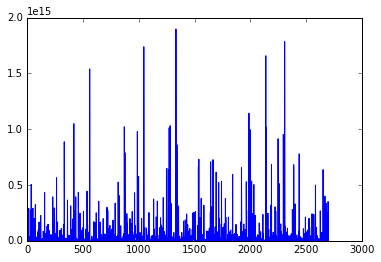

In [18]:
plt.plot(N_HI[100,:])
plt.show()

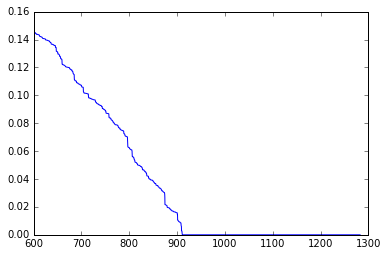

In [19]:
plt.plot(wav_em, t_bf[6,:])

## Add the Lyman-n Forest

$ \tau_{n} = \frac{gf_{1n}}{gf_{Ly\alpha}} \tau_{Ly\alpha} = f_n\tau_{Ly\alpha}$

This function computes the lyman transitions wavelength, finds the corresponding index and adds the opacity due to that line to the total opacity. 

In [20]:
@jit
def tau_HILyn(wave_em, t_HILya, nlines, debug=False, mean=False):
    """ This function computes the Lyman-n forest opacity.
    
        input: emitted wavelength array, Lyman alpha opacity array, number of transitions
        
        returns: array of opacity in the same shape as tau_HILya
    """
    # array of oscillator strengths
    # go backwards since f_n,lambda_n start at lyman alpha
    f_n = (gf_1n(np.arange(2,nlines+3))/gf_1n(2))[::-1]
    
    # array of transition wavelengths
    lambda_n = lyman_lambda(np.arange(2,nlines+2))[::-1]
    
    nfiles = t_HILya.shape[0]
    
    lymanlimit = 911.267050642
    imax = find_nearest(wave_em, lymanlimit)

    # make an empty array to add in the Lyman alpha opacity
    tau_n = np.zeros_like(t_HILya)
    
    # where does wave_em == lyman-n line
    iarr = vec_find_nearest(wave_em,lambda_n)
    
    # good for debugging:
    # print(f_n,iarr, t_HILya[0,iarr[0]]*f_n[0], wave_em[iarr])
    
    for n in xrange(nfiles):
        # do it for each sightline
        for i in range(nlines):
            
            if debug == False and mean == False:
                # stack the opacity onto the opacity array at the index
                # where wavelength == nth lyman line
                tau_n[n,:iarr[i]] += t_HILya[n,:iarr[i]]*f_n[i]
                # print avg
            elif mean == True:
                tau_n[n,:iarr[i]] += np.mean(t_HILya[n,:iarr[i]])*f_n[i]
                # from old code: tau_n[n:] +=  tau_flat[:len(tau_n[n:])]*f_1n[i]
                
            else:
                # good for debugging:
                tau_n[n,:iarr[i]] += f_n[i]   
                
            # tau_n[n,:iarr[i]] += t_HILya[n,:iarr[i]]*f_n[i]
            
    return tau_n

In [21]:
t_Ly_mean = tau_HILyn(wav_em, tau_HILya, num_lines, mean=True)
t_Ly_homogeneous = tau_HILyn(wav_em, tau_HILya, num_lines, debug=True, mean=False)
t_Ly = tau_HILyn(wav_em, tau_HILya, num_lines)

What does a random sightlines Lyman-n opacity looks like:

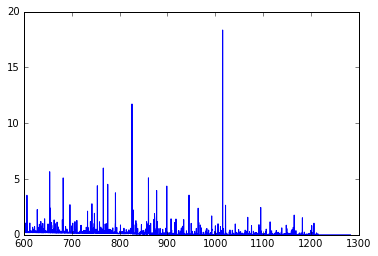

In [22]:
plt.plot(wav_em, t_bf[1,:] + t_Ly[1,:], label=i)
plt.show()

What does a random sightlines combined (Lyman-n & continuum) opacity looks like:

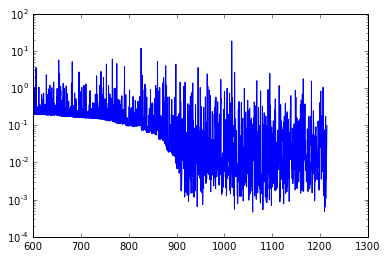

In [23]:
plt.semilogy(wav_em, t_bf[1,:] + t_Ly[1,:])
plt.show()

Compute the average flux over the 2000 sightlines

$$ f = \langle e^{-\tau_{bf+bb}} \rangle $$

### Plot the average spectrum and overlay an individual sightline for comparison. 

In [24]:
tau_tot = t_Ly + t_bf
tau_tot_mean = t_Ly_mean + t_bf
tau_tot_homo = t_Ly_homogeneous + t_bf
tau_tot_slice = t_Ly[399,:] + t_bf[399,:]
# np.mean more accurate with float 64
flux = np.mean(np.exp(-tau_tot*100), axis=0, dtype=np.float64)
flux_mean = np.mean(np.exp(-tau_tot_mean*100), axis=0, dtype=np.float64)
flux_homo = np.mean(np.exp(-tau_tot_homo*100), axis=0, dtype=np.float64)
flux_slice = np.exp(-tau_tot_slice*100)

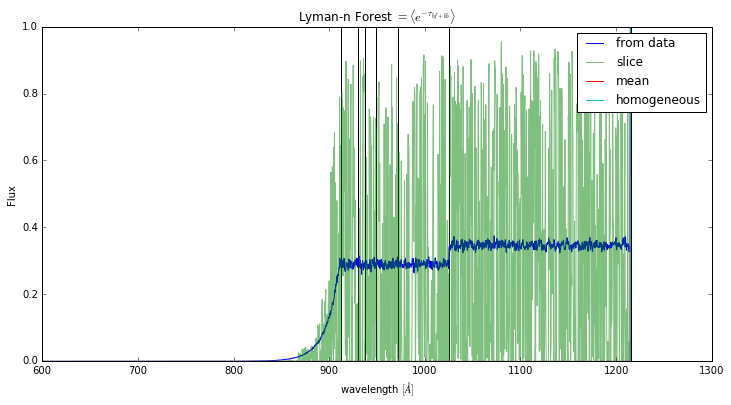

In [25]:
plt.figure(figsize=(12,6))
plt.plot(wav_em, flux, label="from data")
plt.plot(wav_em, flux_slice, alpha=0.5, label="slice")
plt.plot(wav_em, flux_mean, label="mean")
plt.plot(wav_em, flux_homo, label="homogeneous")
ref_lines = lyman_lambda(np.arange(2,8))
plt.vlines(ref_lines, 0, 1)
plt.vlines(912,0,1)
plt.xlabel(r"wavelength $[\AA]$")
plt.ylabel(r"Flux")
plt.title(r"Lyman-n Forest $= \langle e^{-\tau_{bf+bb}} \rangle$")
plt.legend()
plt.show()

# ToDo: 
 - add a mode to include redshift evolution. ie.: after so many boxes shift to a lower redshift
 
 - artificially put down column densities from a simplified $N_{HI}$ distribution drawn from a poisson distribution a guassian profile of width 30 km/s
 


Matt:

number of clusters per bin (N_HI = 10^12.5 to 10^17) = $f L \Delta N_{HI}$

make the clouds gaussian with a width of 20km/s

# Column Density Distribution

In [26]:
@jit(nopython=True)
def opticalDepthProfile(dvv, NHI):
    #sigma = 30 # km/s
    #constants = np.sqrt(2*np.pi*sigma*sigma)
    #gaussian = np.exp(-v*v/(2*sigma*sigma)) / constants
    
    """use a guassian for now. Formula provided by Anson, but check with R.L."""
    # constants
    c = 29979245800.0 # cm/s
    c_km_s = 299792.458 # km/s
    e = 4.80320450571e-10 # gauss
    m_h = 1.672621777e-24 # g
    k = 1.3806488e-16 # cgs
    
    # velocity dispersion
    T = 1e4 # Kelvin
    #sigma_v_squared = 2*k*T/m_h*1e-10 # (km/s)^2
    # should be this
    sigma_v_squared = 32*32
    
    # print np.sqrt(sigma_v_squared)*u.km / u.s
    
    
    # cross section at line center why is this wrong???
    # sigma_Lya = 1 / (np.pi*e**2 * gf_1n(2) / m_h*c)
    sigma_Lya = 4.45e-18
    
    # opacity profile
    tau_v = c_km_s*sigma_Lya*NHI*np.exp(-dvv*dvv/sigma_v_squared)/np.sqrt(sigma_v_squared * np.pi)
    
    return tau_v

# Cosmology

In [27]:
@jit
def H(zz):
    """ returns Hubble parameter as a function of z in units of km/s/Mpc
    """
    omega_m = 0.3
    H0 = 70 # km/s/Mpc
    return H0*np.sqrt(omega_m*(1 + zz)**3)
    

In [28]:
H(z)

245.68990363871285

$$ f(N_{HI},z) = A N^{-\beta}_{HI} (1 + z)^{\gamma} $$

from http://arxiv.org/pdf/1105.2039.pdf 

To convert from $$\frac{\delta^2 N}{\partial N_{HI} \partial z}$$ to $$\frac{\partial^2 N}{\partial N_{HI} \partial v}$$

with $$ \frac{dz}{1+z} = \frac{dv}{c} $$ 


$$\frac{\partial^2 N}{\partial N_{HI} \partial z} \frac{\partial z}{\partial v} = \frac{A N^{-\beta}_{HI} (1 + z)^{\gamma + 1}}{c} $$


In [57]:
@jit
def f_NHI(A, beta, gamma, NHI, zz):
    c_kms = 299792.0 # km/s
    return A * NHI**(-beta) * (1 + zz)**(gamma+1) / c_kms

# @jit
def CDDF(NHI,zz):
    """ if 1e11 < NHI < 1e15:
        beta = 1.5
        A = 10**7.079 # cm^-2 (-beta - 1)
        gamma = 3.0
        return A * NHI**(-beta) * (1 + zz)**gamma
    elif 1e15 < NHI < 10**17.5:
        beta = 2.0
        A = 10**14.580
        gamma = 3
        return A * NHI**(-beta) * (1 + zz)**gamma
    else:
        print("wrong paramter space")
        return None"""
    
    if z < 1.56 or z > 5.5:
        print("Redshift above 5.5 or below 1.56")
        return None
    elif 1e11 < NHI <= 1e15:
        beta = 1.5
        A = 10**7.079 # cm^-2 (-beta - 1)
        gamma = 3.0
        return f_NHI(A, beta, gamma, NHI, zz)
    elif 1e15 < NHI <= 10**17.5:
        beta = 2.0
        A = 10**14.580 # cm^-2 (-beta - 1)
        gamma = 3
        return f_NHI(A, beta, gamma, NHI, zz)
    elif 10**17.5 < NHI <= 1e19:
        # from Haardt and Madau http://arxiv.org/pdf/1105.2039.pdf
        """There is obviously a significant mismatch between the power-law exponent 
        for the Lyα clouds (γ = 3) and the SLLSs (γ = 1.27). Continuity then requires 
        the shape of f(NHI, z) to change with redshift over the column density range 
        of the Lyman-limit systems (LLSs), 10^17.5 < NHI < 10^19 cm−2. In this interval 
        of column densities we match the distribution function with a power law of 
        redshift-dependent slope. The procedure yields the slopes
        β = 0.47, 0.61, 0.72, 0.82 at redshifts z = 2, 3, 4, 5, respectively, 
        in agreement with Prochaska et al. (2010) who find for the LSSs 
        β = 0.8+0.4−0.2 at z ≈ 3.5."""
        
        # the problem is that the normalization constant changes with z: A(z).
        # A = 10**(-0.347)/17402979.94481856 ??
        
        ## NOTE: temp fix for normalization. need to match CDDF at boundary
        ## at z=2.45 A = 1/vecCDDF(10**17.51,2.45)/vecCDDF(10**17.5,2.45)
        ## which implies A = 1/38692217.4381
        
        ## use z = 3.6 to match prochaska et al 2009 mean free path
        
        gamma = 3 
        A = 1. # /vecCDDF(10**17.51,zz)/vecCDDF(10**17.5,zz)
        if 2 <= zz < 3:
            A = 1/38692217.4381
            beta = 0.61
            return f_NHI(A, beta, gamma, NHI, zz)/(1 + zz)**(gamma+1)
        elif 3 <= zz < 4:
            # beta = 0.72 haardt and madua value
            beta = 0.8 # prochaska 2009
            A = 1/5767.2486131289397
            return f_NHI(A, beta, gamma, NHI, zz)/(1 + zz)**(gamma+1)
        elif 4 <= zz < 5:
            beta = 0.82
            return f_NHI(A, beta, gamma, NHI, zz)/(1 + zz)**(gamma+1)
        else:
            print("chose wrong parameter space in LLS regime")
    elif 10**19 <= NHI < 10**20.3:
        beta = 1.05
        A = 10**(-0.347) # cm^-2 (-beta - 1)
        gamma = 1.27
        return f_NHI(A, beta, gamma, NHI, zz)
            
    else:
        print("wrong paramter space")
        return None
    
    
# In order to input an array of NHI in CDDF, need to vectorize.
vecCDDF = np.vectorize(CDDF)

In [58]:
@jit
def singleCDDF(NHI,beta,zz):
    
    # My first attempt at a distribution
    #dN_dxdNHI = 1/(300*u.Mpc)*((1e17*u.cm**-2)**(1.5)) * (NHI*u.cm**-2)**(-1.5)
    dN_dxdNHI = -(1 - beta)/(300)*((1e17)**(-(1 - beta))) * (NHI)**(-beta)
    dN_dvdNHI = dN_dxdNHI * (1+zz) / H(zz)
    return dN_dvdNHI

#oldCDDF = np.vectorize(oldCDDF)

As a check, we get 2.34e-5 systems with $N_{HI} = 1 \times 10^{17}$ cm$^{2}$per km/s so $2$ per $100000$ km/s for the old CDDF (our crude first attempt) and 1.2e-6 for the CDDF from Haardt & Madau (2010)

In [59]:
singleCDDF(1e19,1.5,2.45)*1e19

2.340348510395193e-06

# perhaps make $\beta(z)$ and $A(z)$?

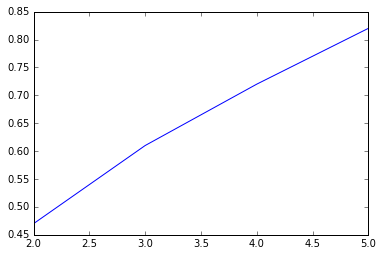

In [60]:
betas = [0.47, 0.61, 0.72, 0.82] 
redshifts = [2, 3, 4, 5]

plt.plot(redshifts, betas)

# Attempt at making normalization a function of z...but should also depend on beta which is itself a function of z for the LLS

In [61]:
A2high = (vecCDDF(10**17.51,2.99)/vecCDDF(10**17.50,2.99))*10**14.580
print A2high
A2low = (vecCDDF(10**17.51,2.0)/vecCDDF(10**17.50,2.0))*10**14.580
print A2low

# print vecCDDF(10**17.50,2.99)


def A_LLS(zz):
    b = A2high - A2low
    A = 10**14.580
    c = A - b*zz
    
    return (high - low)*zz + c

2.12512655204e+14
6.64953630349e+14


In [62]:
print A_LLS(3)
print 10**14.580

NameError: global name 'high' is not defined

In [63]:
# c2 = vecCDDF(10**17.51,3.5)/vecCDDF(10**17.5,3.6)
# c3 = vecCDDF(10**17.51,3.6)/vecCDDF(10**17.5,3.6)

# plt.plot([3.5,2.99],[c2,c3])

vecCDDF(10**17.51,3.6)/vecCDDF(10**17.5,3.6)

1.0

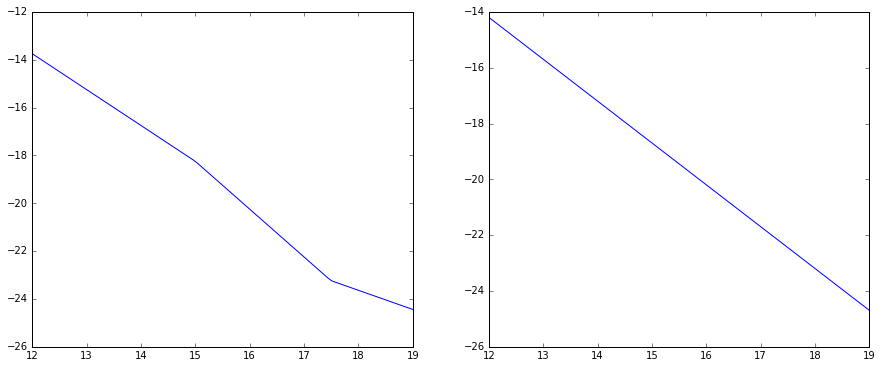

In [64]:
test_z = 3.6
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
N = np.logspace(12,19,100)
ax[0].plot(np.log10(N),np.log10(vecCDDF(N,test_z)))
ax[1].plot(np.log10(N),np.log10(singleCDDF(N,1.5,test_z)))

# A Faster make Synthetic Skewer function

put things in arrays so loops are quicker

In [35]:
@jit(nopython=True)
def makeOptArray(NHI):
    """ Make an array of optical depth profile arrays with the shape corresponding to
        the number of column density """
    M = NHI.shape[0]
    # N = opticalDepthProfileArray(imax,NHI[0]).shape[0]
    N = 2*imax
    optArray = np.empty((M, N), dtype=np.float32)
    for j,iNHI in enumerate(NHI):
        for i in xrange(-imax, imax, 1):
            optArray[j,i] = (opticalDepthProfile(i, iNHI))
    return optArray

@jit(nopython=True)
def numba_poisson(X):
    num_absorbers = np.empty_like(X,dtype=np.int32)
    for i,x in enumerate(X):
        num_absorbers[i] = np.random.poisson(x)
    return num_absorbers

@jit(nopython=True)
def numba_randint(low, high, size):
    rand = np.empty(size, dtype=np.int64)
    for i in xrange(size):
        rand[i] = np.random.randint(low,high)
    return rand

In [68]:
@jit(nopython=True)
def makeOptArray(NHI):
    """ Make an array of optical depth profile arrays with the shape corresponding to
        the number of column density """
    M = NHI.shape[0]
    # N = opticalDepthProfileArray(imax,NHI[0]).shape[0]
    N = 2*imax
    optArray = np.empty((M, N), dtype=np.float32)
    for j,iNHI in enumerate(NHI):
        for i in xrange(-imax, imax, 1):
            optArray[j,i] = (opticalDepthProfile(i, iNHI))
    return optArray

@jit(nopython=True)
def numba_poisson(X):
    num_absorbers = np.empty_like(X,dtype=np.int32)
    for i,x in enumerate(X):
        num_absorbers[i] = np.random.poisson(x)
    return num_absorbers

@jit(nopython=True)
def numba_randint(low, high, size):
    rand = np.empty(size, dtype=np.int64)
    for i in xrange(size):
        rand[i] = np.random.randint(low,high)
    return rand

@jit
def fast_makeSyntheticSkewer(z, beta):
    """ creates a skewer with a column density distribution drawn from a power law with
        an exponent of beta.
        
        Numba speed up is 10x but not fully working on the array slicing at the bottom
    
    """
    width = 30. # km/s
    # From Anson:
    #This is just a sketch of how you might want to code the contruction
    #of random spectra (not meant to be working code). You will have to define
    #the constants and functions that are relevant for your calculation. 
    #I extracted this fragment from some of Matt McQuinn's code

    #Set the span of the line profiles of your absorbers.  Here width
    #is the resolution element of your mock spectrum.   
    imax = int(900./width)

    logNMAX = 19.0
    logNMIN = 12.5

    skewer = np.zeros_like(wav_em)
    skewer_size = len(skewer) 
    skewer_length = skewer_size*dv # km/s

    #You will first want to set the number of logarithmic bins in NHI
    numN = 40
    dlogN = (logNMAX-logNMIN)/numN

    # an array of column densities
    NHI = 10**(dlogN*np.arange(numN) + logNMIN)

    # an array of the number of absorbers per dNHI (so an array of 20 num_absorbers)
    # num_absorbers = np.random.poisson(skewer_length*CDDF(NHI,-1.5,z)*dlogN*NHI)
    num_absorbers = numba_poisson(skewer_length*singleCDDF(NHI,beta,z)*dlogN*NHI)

    # Make an array of optical depth profile arrays with the shape corresponding to
    # the number of column density bins x the length of the optical depth profiles 
    M = numN
    N = 2*imax
    optArray = np.empty((M, N), dtype=np.float32)
    for j,iNHI in enumerate(NHI):
        for i in xrange(-imax, imax, 1):
            optArray[j,i] = opticalDepthProfile(i, iNHI)

    # an array of random points from 0 to skewer_size 
    # make the size the largest number of absorbers
    random_point = numba_randint(0,skewer_size+1, np.max(num_absorbers))
    
    for k in xrange(numN):
        for j in xrange(num_absorbers[k]):
            start = (random_point[j]-imax + skewer_size)%skewer_size
            stop = (random_point[j]+imax + skewer_size)%skewer_size
            # if the random point is too near the edge it fails...
            if start > stop:
                # nopython=True fails here...dont know why
                # TypeError: Cannot modify value of type readonly array(float64, 1d, C)
                skewer[start:] += optArray[k,:skewer_size - start]
                skewer[:stop] += optArray[k,skewer_size - start:]
            else:
                skewer[start:stop] += optArray[k,:]
    return skewer

In [71]:
def makeSkewerArray(numSkewers, z, beta):
    return np.asarray([fast_makeSyntheticSkewer(z, beta) for x in xrange(numSkewers)])

In [97]:
def makeSkewerArray(numSkewers, z, beta):
    N = numSkewers
    skewer_list = []
    for i in xrange(N):
        skewer_list.append(fast_makeSyntheticSkewer(z, beta))
            
    return np.asarray(skewer_list)

In [98]:
%timeit makeSkewerArray(10,3.6,1.5)

100 loops, best of 3: 1.91 ms per loop


# Plot the synthetic spectra

In [ ]:
def makeSpectra(num_lines, z, numSkewers, beta):
    synth_arr = makeSkewerArray(numSkewers,z, beta)
    tau_Lya_synth = tau_HILyn(wav_em, synth_arr, num_lines)
    N_HI_synth = make_column_density(synth_arr)
    t_bf_synth = tau_bf(wav_em, N_HI_synth)
    tau_tot_synth = tau_Lya_synth + t_bf_synth
    flux = np.mean(np.exp(-tau_tot_synth), axis=0, dtype=np.float64)
    plt.plot(wav_em, flux,label="mean")
    plt.plot(wav_em, np.exp(-tau_tot_synth[0]),label="single skewer")
    plt.legend()
    plt.xlim(850,970)

In [ ]:
makeSpectra(100,z,150, 1.5)

In [66]:
def makeSpectra_bf(num_lines, z, numSkewers, beta):
    synth_arr = makeSkewerArray(numSkewers, z, beta)
    tau_Lya_synth = tau_HILyn(wav_em, synth_arr, num_lines)
    N_HI_synth = make_column_density(synth_arr)
    t_bf_synth = tau_bf(wav_em, N_HI_synth)
    tau_tot_synth = t_bf_synth
    flux = np.mean(np.exp(-tau_tot_synth), axis=0, dtype=np.float64)
    plt.plot(wav_em, flux,label="mean")
    plt.plot(wav_em, np.exp(-tau_tot_synth[19]),label="single skewer")
    #plt.plot(wav_em, np.exp(-tau_tot_synth[1]),label="single skewer")
    #plt.plot(wav_em, np.exp(-tau_tot_synth[21]),label="single skewer")
    #plt.plot(wav_em, np.exp(-tau_tot_synth[17]),label="single skewer")
    #plt.plot(wav_em, np.exp(-tau_tot_synth[11]),label="single skewer")
    plt.legend()
    plt.xlim(850,970)

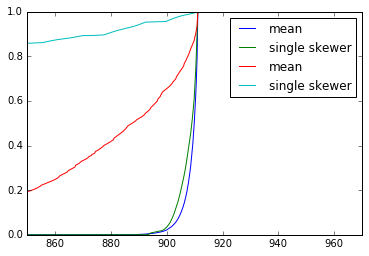

In [99]:
makeSpectra_bf(100,z,150, 1.8)
makeSpectra_bf(100,z,150, 1.5)

In [ ]:
def makeSpectra_Lyn(num_lines, z, numSkewers):
    synth_arr = makeSkewerArray(numSkewers,z)
    tau_Lya_synth = tau_HILyn(wav_em, synth_arr, num_lines)
    N_HI_synth = make_column_density(synth_arr)
    t_bf_synth = tau_bf(wav_em, N_HI_synth)
    tau_tot_synth = tau_Lya_synth
    flux = np.mean(np.exp(-tau_tot_synth), axis=0, dtype=np.float64)
    plt.plot(wav_em, flux,label="mean")
    plt.plot(wav_em, np.exp(-tau_tot_synth[150]),label="single skewer")
    plt.legend()
    # plt.xlim(850,970)

In [ ]:
makeSpectra_Lyn(100,z,2000)

# compute the variance as a function of wavelength 

In [ ]:
def continuum_variance(z, numSkewers,beta):
    synth_arr = makeSkewerArray(numSkewers,z,beta)
    # tau_Lya_synth = tau_HILyn(wav_em, synth_arr, num_lines)
    N_HI_synth = make_column_density(synth_arr)
    t_bf_synth = tau_bf(wav_em, N_HI_synth)
    tau_tot_synth = t_bf_synth
    flux = np.exp(-tau_tot_synth)
    mean = np.mean(np.exp(-tau_tot_synth), axis=0, dtype=np.float64)
    # print flux.shape
    var = np.sqrt(np.var(flux,axis=0))/mean
    return var

def total_variance(z, numSkewers):
    synth_arr = makeSkewerArray(numSkewers,z)
    tau_Lya_synth = tau_HILyn(wav_em, synth_arr, num_lines)
    N_HI_synth = make_column_density(synth_arr)
    t_bf_synth = tau_bf(wav_em, N_HI_synth)
    tau_tot_synth = t_bf_synth + tau_Lya_synth
    flux = np.exp(-tau_tot_synth)
    print flux.shape
    var = np.var(flux,axis=0)
    return var

In [ ]:
cont_var15 = continuum_variance(2.45, 200, -.5)
cont_var10 = continuum_variance(2.45, 200, 1.0)
cont_var20 = continuum_variance(2.45, 200, 0)
# tot_var = total_variance(2.45,2000)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(wav_em, cont_var15, label=r"$\beta = 1.5$")
plt.plot(wav_em, cont_var10, label=r"$\beta = 1.0$")
plt.plot(wav_em, cont_var20, label=r"$\beta = 2.0$")
plt.xlabel(r"wavelength $[\AA]$")
plt.ylabel(r"$\sqrt{\sigma^2}$ / mean Flux")
plt.title(r"Variance of the Lyman continuum flux for Haardt & Madau 2012 CDDF")
plt.legend()
plt.plot()
plt.show()

# need to normalize single power law distributions to the mean free path (not finished)

In [ ]:
def f(NHI,A,beta,gamma):
    return A*NHI**(-beta)*(1+z)**gamma

def normalize_CDDF(CDDF(NHI,z)):
    sigma912 = 6.30e-18
    beta = 1
    A = sigma912*(beta-1)*NHI
    
    

In [ ]:
def a(x,c):
    return c*x**2
def test(b):
    nh2 = 10
    return b*2

In [ ]:
@jit
def __makeSyntheticSkewer(beta, z):
    """ Note: this is depricated as it is much slower than fast_makeSyntheticSkewer()"""
    
    width = 30 # km/s
    #This is just a sketch of how you might want to code the contruction
    #of random spectra (not meant to be working code). You will have to define
    #the constants and functions that are relevant for your calculation. 
    #I extracted this fragment from some of Matt McQuinn's code

    #Set the span of the line profiles of your absorbers.  Here dv
    #is the resolution element of your mock spectrum.   
    imax = int(300/width)

    logNMAX = 19
    logNMIN = 12.5

    skewer = np.zeros_like(wav_em)
    
    # skewer_size = wav_em.size
    # skewer = np.zeros(3000)
    skewer_size = np.size(skewer) 
    skewer_length = skewer_size*dv # km/s


    #You will first want to set the number of logarithmic bins in NHI
    numN = 40
    dlogN = (logNMAX-logNMIN)/numN

    #Loop over the NHI bins
    for ii in range(numN):

        NHI = 10**(dlogN*ii + logNMIN)

        #Draw from a Poisson distribution the number of absorbers along the sightline with NHI in this bin.  
        #Note that if you want to do this in velocity space, you will want the CDDF to be expressed as the 
        #number of absorbers per km/s per logNHI, and you will want "skewer_length" to be in km/s 
        num_absorbers = np.random.poisson(skewer_length*CDDF(NHI,-1.5,z)*dlogN*NHI)

        # print skewer_size*CDDF(NHI,z)*dlogN, num_absorbers, imax

        #Now lay down the absorbers at a random location along your sightline
        #Loop over absorbers in this NHI bin
        for j in xrange(num_absorbers):

            #The random location of the absorber
            random_point = np.random.randint(0,skewer_size+1)
            # random_point = randomPointArray[j]

            #Add the opacity of this absorber to your sightline
            #The extent of the line profile is set by imax
            for i in xrange(-imax, imax, 1):

                #This mod (%) enforces periodic boundaries
                #Here the opticalDepthProfile should be your line profile (e.g. Gaussian)
                skewer[(random_point+i + skewer_size)%skewer_size] += opticalDepthProfile(i*width, NHI)

    return skewer

In [ ]:
test(a(nh2,2))